# py12box model usage

This notebook shows how to set up and run the AGAGE 12-box model.

## Model schematic

The model uses advection and diffusion parameters to mix gases between boxes. Box indices start at the northern-most box and are as shown in the following schematic:

<img src="box_model_schematic.png" alt="Box model schematic" style="display:block;margin-left:auto;margin-right:auto;width:20%"/>

## Model inputs

We will be using some synthetic inputs for CFC-11. Input files are in:

```data/example/CFC-11```

The location of this folder will depend on where you've installed py12box and your system. Perhaps the easiest place to view the contents is [in the repository](https://github.com/mrghg/py12box/tree/develop/py12box/data/example/CFC-11).

In this folder, you will see two files:

```CFC-11_emissions.csv```

```CFC-11_initial_conditions.csv```

As the names suggest, these contain the emissions, initial conditions and lifetimes.

### Emissions
The emissions file has four columns: ```year, box_1, box_2, box_3, box_4```. 

The number of rows in this file determines the length of the box model simulation.

The ```year``` column should contain a decimal date (e.g. 2000.5 for ~June 2000), and can be monthly or annual resolution.

The other columns specify the emissions in Gg/yr in each surface box.

### Initial conditions

The initial conditions file can be used to specify the mole fraction in pmol/mol (~ppt) in each of the 12 boxes.


## How to run

Firstly import the ```Model``` class. This class contains all the input variables (emissions, initial conditions, etc., and run functions).

We are also importing the get_data helper function, only needed for this tutorial, to point to input data files.

In [1]:
# Import from this package
from py12box.model import Model
from py12box import get_data

# Import matplotlib for some plots
import matplotlib.pyplot as plt

The ```Model``` class takes two arguments, ```species``` and ```project_directory```. The latter is the location of the input files, here just redirecting to the "examples" folder.

The initialisation step may take a few seconds, mainly to compile the model.

In [2]:
# Initialise the model
mod = Model("CFC-11", get_data("example/CFC-11"))


Compiling model and tuning lifetime...
... completed in 3 iterations
... stratospheric lifetime: 52.1
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e12
... overall lifetime: 52.0
... done in 5.5602850914001465 s


Assuming this has compiled correctly, you can now check the model inputs by accessing elements of the model class. E.g. to see the emissions:

In [3]:
mod.emissions

array([[100,  10,   0,   0],
       [100,  10,   0,   0],
       [100,  10,   0,   0],
       ...,
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]])

In this case, the emissions should be a 4 x 12*n_years numpy array. If annual emissions were specified in the inputs, the annual mean emissions are repeated each month.

We can now run the model using:

In [4]:
# Run model
mod.run()

... done in 0.024969100952148438 s


The primary outputs that you'll be interested in are ```mf``` for the mole fraction (pmol/mol) in each of the 12 boxes at each timestep.

Let's plot this up:

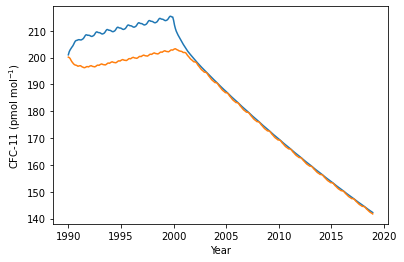

In [5]:
plt.plot(mod.time, mod.mf[:, 0])
plt.plot(mod.time, mod.mf[:, 3])
plt.ylabel("%s (pmol mol$^{-1}$)" % mod.species)
plt.xlabel("Year")
plt.show()

We can also view other outputs such as the burden and loss. Losses are contained in a dictionary, with keys:
- ```OH``` (tropospheric OH losses)
- ```Cl``` (losses via tropospheric chlorine)
- ```other``` (all other first order losses)

For CFC-11, the losses are primarily in the stratosphere, so are contained in ```other```:

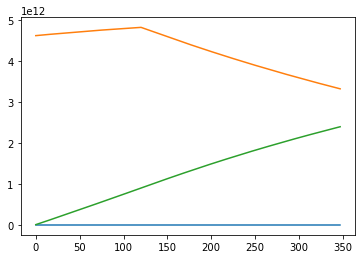

In [6]:
plt.plot(mod.emissions.sum(axis = 1).cumsum())
plt.plot(mod.burden.sum(axis = 1))
plt.plot(mod.losses["other"].sum(axis = 1).cumsum())

Another useful output is the lifetime. This is broken down in a variety of ways. Here we'll plot the global lifetime:

Text(0, 0.5, 'Global instantaneous lifetime (years)')

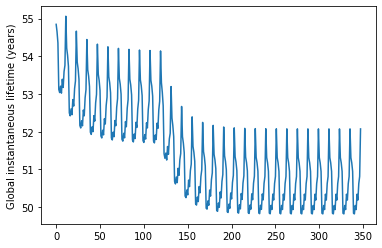

In [7]:
plt.plot(mod.instantaneous_lifetimes["global_total"])
plt.ylabel("Global instantaneous lifetime (years)")

## Setting up your own model run

To create your own project, create a project folder (can be anywhere on your filesystem). 
The folder must contain two files:

```<species>_emissions.csv```

```<species>_initial_conditions.csv```

To point to the new project, py12box will expect a pathlib.Path object, so make sure you import this first:

In [ ]:
from pathlib import Path
new_model = Model("<SPECIES>", Path("path/to/project/folder"))

Once set up, you can run the model using:

In [ ]:
new_model.run()

Note that you can modify any of the model inputs in memory by modifying the model class. E.g. to see what happens when you double the emissions:

In [ ]:
new_model.emissions *= 2.
new_model.run()

## Changing lifetimes

If no user-defined lifetimes are passed to the model, it will use the values in ```data/inputs/species_info.csv```

However, you can start the model up with non-standard lifetimes using the following arguments to the ```Model``` class (all in years):

```lifetime_strat```: stratospheric lifetime

```lifetime_ocean```: lifetime with respect to ocean uptake

```lifetime_trop```: non-OH losses in the troposphere

e.g.:


In [ ]:
new_model = Model("<SPECIES>", Path("path/to/project/folder"), lifetime_strat=100.)

To change the tropospheric OH lifetime, you need to modify the ```oh_a``` or ```oh_er``` attributes of the ```Model``` class.

To re-tune the lifetime of the model in-memory, you can use the ```tune_lifetime``` method of the ```Model``` class:

In [ ]:
new_model.tune_lifetime(lifetime_strat=50., lifetime_ocean=1e12, lifetime_trop=1e12)